<h3>Part 1 -- Autoencoder </h3>
<h5>Each cifar image is 32 X 32 X 3. This will be compressed to ?? using an autoencoder (784 variables to 64 variables).</h5>

In [37]:
from keras.datasets import cifar100
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential, load_model

import copy
import matplotlib.pyplot as plt
import numpy as np
from autoencoder_utils import *
import math

(X_train, _), (X_test, _) = cifar100.load_data(label_mode='fine')

X_train = np.reshape(X_train, (len(X_train), 32, 32, 3)) / 255.
X_test = np.reshape(X_test, (len(X_test), 32, 32, 3)) / 255.

In [38]:
autoencoder = Sequential()

input_shape = (32, 32, 3)
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))

autoencoder.add(Conv2D(4, (3, 3), activation='sigmoid', padding='same', name='encoded_layer'))
# autoencoder.add(MaxPooling2D((2, 2)))

# autoencoder.add(Conv2D(4, (1, 1), activation='sigmoid', padding='same', name='encoded_layer')) #to convert all to values between 0 and 1, for comparison later on using binary_crossentropy
#at this point, 'encoded' is (8, 8, 4)

# autoencoder.add(UpSampling2D((2, 2)))
# autoencoder.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same', kernel_initializer='he_normal'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [ ]:
epochs = 40
batch_size = 64
training_batch_size = 1000
number_training_batch_per_epoch = math.ceil(X_train.shape[0] / training_batch_size)

#not the most ideal way of iterating through a dataset
for epoch in range(epochs):
    print('epoch: {}'.format(epoch))
    np.random.shuffle(X_train)
    np.random.shuffle(X_test)
    for batchnum in range(number_training_batch_per_epoch):
        X_train_batch = X_train[batchnum*training_batch_size : (batchnum+1)*training_batch_size]
        autoencoder.fit(X_train_batch, X_train_batch,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_test[0:200], X_test[0:200]))


epoch: 0
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 4s - loss: 0.6817 - binary_crossentropy: 0.6817 - val_loss: 0.6578 - val_binary_crossentropy: 0.6578
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.6400 - binary_crossentropy: 0.6400 - val_loss: 0.6131 - val_binary_crossentropy: 0.6131
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.6036 - binary_crossentropy: 0.6036 - val_loss: 0.5962 - val_binary_crossentropy: 0.5962
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5971 - binary_crossentropy: 0.5971 - val_loss: 0.5903 - val_binary_crossentropy: 0.5903
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5885 - binary_crossentropy: 0.5885 - val_loss: 0.5837 - val_bina

1000/1000 [==============================] - 1s - loss: 0.5600 - binary_crossentropy: 0.5600 - val_loss: 0.5516 - val_binary_crossentropy: 0.5516
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5564 - binary_crossentropy: 0.5564 - val_loss: 0.5507 - val_binary_crossentropy: 0.5507
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5531 - binary_crossentropy: 0.5531 - val_loss: 0.5499 - val_binary_crossentropy: 0.5499
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5522 - binary_crossentropy: 0.5522 - val_loss: 0.5507 - val_binary_crossentropy: 0.5507
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5535 - binary_crossentropy: 0.5535 - val_loss: 0.5501 - val_binary_crossentropy: 0.5501
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5457 - binary_crossentropy: 0.5457 - val_loss: 0.5377 - val_binary_crossentropy: 0.5377
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5458 - binary_crossentropy: 0.5458 - val_loss: 0.5375 - val_binary_crossentropy: 0.5375
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5473 - binary_crossentropy: 0.5473 - val_loss: 0.5387 - val_binary_crossentropy: 0.5387
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5528 - binary_crossentropy: 0.5528 - val_loss: 0.5382 - val_binary_crossentropy: 0.5382
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5501 - binary_crossentropy: 0.5501 - val_loss: 0.5381 - val_binary_crossentropy: 0.5381
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5410 - binary_crossentropy: 0.5410 - val_loss: 0.5384 - val_binary_crossentropy: 0.5384
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5472 - binary_crossentropy: 0.5472 - val_loss: 0.5391 - val_binary_crossentropy: 0.5391
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5453 - binary_crossentropy: 0.5453 - val_loss: 0.5397 - val_binary_crossentropy: 0.5397
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5454 - binary_crossentropy: 0.5454 - val_loss: 0.5465 - val_binary_crossentropy: 0.5465
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5549 - binary_crossentropy: 0.5549 - val_loss: 0.5542 - val_binary_crossentropy: 0.5542
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5416 - binary_crossentropy: 0.5416 - val_loss: 0.5392 - val_binary_crossentropy: 0.5392
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5452 - binary_crossentropy: 0.5452 - val_loss: 0.5388 - val_binary_crossentropy: 0.5388
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5419 - binary_crossentropy: 0.5419 - val_loss: 0.5391 - val_binary_crossentropy: 0.5391
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5386 - binary_crossentropy: 0.5386 - val_loss: 0.5395 - val_binary_crossentropy: 0.5395
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5468 - binary_crossentropy: 0.5468 - val_loss: 0.5391 - val_binary_crossentropy: 0.5391
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5489 - binary_crossentropy: 0.5489 - val_loss: 0.5456 - val_binary_crossentropy: 0.5456
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5373 - binary_crossentropy: 0.5373 - val_loss: 0.5451 - val_binary_crossentropy: 0.5451
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5415 - binary_crossentropy: 0.5415 - val_loss: 0.5461 - val_binary_crossentropy: 0.5461
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5462 - binary_crossentropy: 0.5462 - val_loss: 0.5450 - val_binary_crossentropy: 0.5450
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5444 - binary_crossentropy: 0.5444 - val_loss: 0.5442 - val_binary_crossentropy: 0.5442
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5390 - binary_crossentropy: 0.5390 - val_loss: 0.5450 - val_binary_crossentropy: 0.5450
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5428 - binary_crossentropy: 0.5428 - val_loss: 0.5438 - val_binary_crossentropy: 0.5438
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5361 - binary_crossentropy: 0.5361 - val_loss: 0.5435 - val_binary_crossentropy: 0.5435
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5383 - binary_crossentropy: 0.5383 - val_loss: 0.5434 - val_binary_crossentropy: 0.5434
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5381 - binary_crossentropy: 0.5381 - val_loss: 0.5432 - val_binary_crossentropy: 0.5432
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5394 - binary_crossentropy: 0.5394 - val_loss: 0.5416 - val_binary_crossentropy: 0.5416
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5392 - binary_crossentropy: 0.5392 - val_loss: 0.5417 - val_binary_crossentropy: 0.5417
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5459 - binary_crossentropy: 0.5459 - val_loss: 0.5440 - val_binary_crossentropy: 0.5440
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5427 - binary_crossentropy: 0.5427 - val_loss: 0.5420 - val_binary_crossentropy: 0.5420
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5371 - binary_crossentropy: 0.5371 - val_loss: 0.5411 - val_binary_crossentropy: 0.5411
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5402 - binary_crossentropy: 0.5402 - val_loss: 0.5415 - val_binary_crossentropy: 0.5415
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5419 - binary_crossentropy: 0.5419 - val_loss: 0.5418 - val_binary_crossentropy: 0.5418
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5388 - binary_crossentropy: 0.5388 - val_loss: 0.5414 - val_binary_crossentropy: 0.5414
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5429 - binary_crossentropy: 0.5429 - val_loss: 0.5421 - val_binary_crossentropy: 0.5421
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5398 - binary_crossentropy: 0.5398 - val_loss: 0.5415 - val_binary_crossentropy: 0.5415
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5395 - binary_crossentropy: 0.5395 - val_loss: 0.5433 - val_binary_crossentropy: 0.5433
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5422 - binary_crossentropy: 0.5422 - val_loss: 0.5422 - val_binary_crossentropy: 0.5422
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5417 - binary_crossentropy: 0.5417 - val_loss: 0.5452 - val_binary_crossentropy: 0.5452
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5360 - binary_crossentropy: 0.5360 - val_loss: 0.5462 - val_binary_crossentropy: 0.5462
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5389 - binary_crossentropy: 0.5389 - val_loss: 0.5434 - val_binary_crossentropy: 0.5434
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5307 - binary_crossentropy: 0.5307 - val_loss: 0.5247 - val_binary_crossentropy: 0.5247
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5392 - binary_crossentropy: 0.5392 - val_loss: 0.5328 - val_binary_crossentropy: 0.5328
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5420 - binary_crossentropy: 0.5420 - val_loss: 0.5263 - val_binary_crossentropy: 0.5263
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5311 - binary_crossentropy: 0.5311 - val_loss: 0.5250 - val_binary_crossentropy: 0.5250
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5318 - binary_crossentropy: 0.5318 - val_loss: 0.5243 - val_binary_crossentropy: 0.5243
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5370 - binary_crossentropy: 0.5370 - val_loss: 0.5244 - val_binary_crossentropy: 0.5244
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5369 - binary_crossentropy: 0.5369 - val_loss: 0.5237 - val_binary_crossentropy: 0.5237
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5421 - binary_crossentropy: 0.5421 - val_loss: 0.5239 - val_binary_crossentropy: 0.5239
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5323 - binary_crossentropy: 0.5323 - val_loss: 0.5239 - val_binary_crossentropy: 0.5239
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5364 - binary_crossentropy: 0.5364 - val_loss: 0.5239 - val_binary_crossentropy: 0.5239
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5369 - binary_crossentropy: 0.5369 - val_loss: 0.5331 - val_binary_crossentropy: 0.5331
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5388 - binary_crossentropy: 0.5388 - val_loss: 0.5308 - val_binary_crossentropy: 0.5308
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5375 - binary_crossentropy: 0.5375 - val_loss: 0.5305 - val_binary_crossentropy: 0.5305
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5352 - binary_crossentropy: 0.5352 - val_loss: 0.5304 - val_binary_crossentropy: 0.5304
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5340 - binary_crossentropy: 0.5340 - val_loss: 0.5343 - val_binary_crossentropy: 0.5343
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5395 - binary_crossentropy: 0.5395 - val_loss: 0.5303 - val_binary_crossentropy: 0.5303
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5340 - binary_crossentropy: 0.5340 - val_loss: 0.5307 - val_binary_crossentropy: 0.5307
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5321 - binary_crossentropy: 0.5321 - val_loss: 0.5303 - val_binary_crossentropy: 0.5303
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5407 - binary_crossentropy: 0.5407 - val_loss: 0.5328 - val_binary_crossentropy: 0.5328
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5419 - binary_crossentropy: 0.5419 - val_loss: 0.5306 - val_binary_crossentropy: 0.5306
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5362 - binary_crossentropy: 0.5362 - val_loss: 0.5480 - val_binary_crossentropy: 0.5480
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5325 - binary_crossentropy: 0.5325 - val_loss: 0.5499 - val_binary_crossentropy: 0.5499
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5323 - binary_crossentropy: 0.5323 - val_loss: 0.5487 - val_binary_crossentropy: 0.5487
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5333 - binary_crossentropy: 0.5333 - val_loss: 0.5483 - val_binary_crossentropy: 0.5483
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5368 - binary_crossentropy: 0.5368 - val_loss: 0.5484 - val_binary_crossentropy: 0.5484
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5345 - binary_crossentropy: 0.5345 - val_loss: 0.5298 - val_binary_crossentropy: 0.5298
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5348 - binary_crossentropy: 0.5348 - val_loss: 0.5296 - val_binary_crossentropy: 0.5296
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5318 - binary_crossentropy: 0.5318 - val_loss: 0.5312 - val_binary_crossentropy: 0.5312
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5336 - binary_crossentropy: 0.5336 - val_loss: 0.5301 - val_binary_crossentropy: 0.5301
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5366 - binary_crossentropy: 0.5366 - val_loss: 0.5308 - val_binary_crossentropy: 0.5308
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5353 - binary_crossentropy: 0.5353 - val_loss: 0.5302 - val_binary_crossentropy: 0.5302
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5298 - binary_crossentropy: 0.5298 - val_loss: 0.5298 - val_binary_crossentropy: 0.5298
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5364 - binary_crossentropy: 0.5364 - val_loss: 0.5293 - val_binary_crossentropy: 0.5293
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5355 - binary_crossentropy: 0.5355 - val_loss: 0.5293 - val_binary_crossentropy: 0.5293
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5387 - binary_crossentropy: 0.5387 - val_loss: 0.5314 - val_binary_crossentropy: 0.5314
Train on 1000 samples, validate on 200 sam

1000/1000 [==============================] - 1s - loss: 0.5291 - binary_crossentropy: 0.5291 - val_loss: 0.5352 - val_binary_crossentropy: 0.5352
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5306 - binary_crossentropy: 0.5306 - val_loss: 0.5344 - val_binary_crossentropy: 0.5344
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5347 - binary_crossentropy: 0.5347 - val_loss: 0.5345 - val_binary_crossentropy: 0.5345
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5329 - binary_crossentropy: 0.5329 - val_loss: 0.5353 - val_binary_crossentropy: 0.5353
Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.5314 - binary_crossentropy: 0.5314 - val_loss: 0.5348 - val_binary_crossentropy: 0.5348
Train on 1000 samples, validate on 200 sam

In [36]:
# from h5py import h5py

# autoencoder.save('autoencoder_cifar100_bincrossentropy.h5')
# autoencoder = load_model('autoencoder_cifar100.h5')

<h5>
The code below displays the original and autoencoded versions of 10 images.
<br>
They look pretty similar
</h5>

(10, 32, 32, 3)


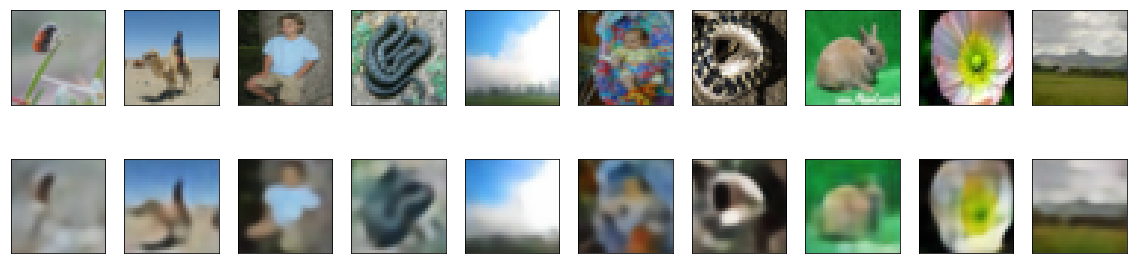

In [24]:
n = 10
img_to_show_idx = np.random.choice(range(X_test.shape[0]), n, replace=False)
X_test_to_show = X_test[img_to_show_idx]
print(X_test_to_show.shape)
aft_autoencode = autoencoder.predict(X_test_to_show)

fig = plt.figure(figsize=(n*2, 5))
plt.gray()
img_shape = (32, 32, 3)

for i in range(n):
    #display original
    display_single_subplot(X_test_to_show[i].reshape(img_shape), n_row=2, n_col=n, cell_num=i+1)
    #display aft autoencoding
    display_single_subplot(aft_autoencode[i].reshape(img_shape), n_row=2, n_col=n, cell_num=n+i+1)

plt.show()

<h3>
Part 2 -- selecting similar images
</h3>
<h5>
Given an image, select the most similar and dissimilar images, using binary cross entropy to determine similarity
</h5>

In [34]:
#find images similar to the image at this index
img_to_find_idx = 0

layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, img_to_find_idx, dataset=X_test, loss='cosine_proximity')


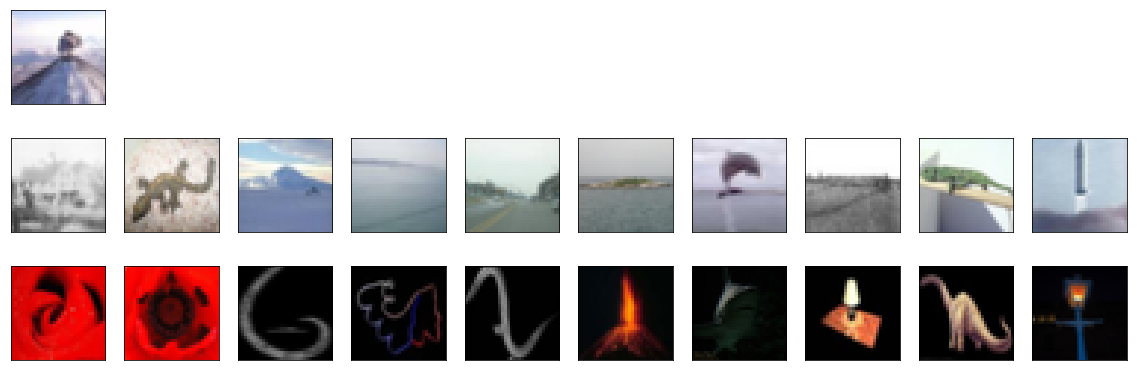

In [35]:
#show original image, n most similar images, n most dissimilar images
n = 10
image_dataset = X_test

plt.figure(figsize=(n*2, n/1.5))
img_shape = (32, 32, 3)

#display original
display_single_subplot(image_dataset[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

# #display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(image_dataset[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)

# #display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(image_dataset[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()

In [88]:
similarity_sorted[-1]

5848